In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Run this cell locally to set up Spark. On AWS EMR the "spark" context is provided already
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = """\
    --conf spark.driver.bindAddress=localhost \
    --conf spark.driver.host=localhost \
    --packages "org.apache.hadoop:hadoop-aws:2.7.3" pyspark-shell"""
os.environ['SPARK_MASTER_HOST'] = 'localhost'
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
conf = SparkConf()\
    .setMaster("local")\
    .setAppName("daily-average-air-temp")\
    .set("spark.sql.parquet.compression.codec", "snappy")
sc = SparkContext(conf=conf)
spark = SQLContext(sc)

In [46]:
parquetFile = spark.read.parquet("noaa_isd_data_SD_2000_to_2020.parquet.gzip")
parquetFile.createOrReplaceTempView("parquetFile")
spark.sql("SELECT * FROM parquetFile WHERE NOT air_temp_c IS NULL LIMIT 5").collect()

[Row(var_data_len=145, usaf_station_id='722903', wban_station_id='99999', date=datetime.datetime(1999, 12, 31, 16, 53), latitude=32.82, longitude=-117.13, report_type='FM-15', elevation_meters=129.0, call_letters='KMYF ', qc_process='V02', air_temp_c=12.0),
 Row(var_data_len=213, usaf_station_id='722903', wban_station_id='99999', date=datetime.datetime(1999, 12, 31, 17, 53), latitude=32.82, longitude=-117.13, report_type='FM-15', elevation_meters=129.0, call_letters='KMYF ', qc_process='V02', air_temp_c=12.0),
 Row(var_data_len=266, usaf_station_id='722903', wban_station_id='99999', date=datetime.datetime(1999, 12, 31, 18, 53), latitude=32.82, longitude=-117.13, report_type='FM-15', elevation_meters=129.0, call_letters='KMYF ', qc_process='V02', air_temp_c=11.0),
 Row(var_data_len=174, usaf_station_id='722903', wban_station_id='99999', date=datetime.datetime(1999, 12, 31, 19, 53), latitude=32.82, longitude=-117.13, report_type='FM-15', elevation_meters=129.0, call_letters='KMYF ', qc_p

In [49]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

parquetFile = parquetFile.withColumn("date_trunc", F.to_date(F.col("date")))
parquetFile = parquetFile.withColumn("station_id",
                     F.concat(
                         F.concat(F.col("usaf_station_id").cast("string"), F.lit("-")),
                         F.col("wban_station_id").cast("string")))
parquetFile.createOrReplaceTempView("parquetFile")
spark.sql("SELECT station_id, date, date_trunc FROM parquetFile LIMIT 5").collect()

[Row(station_id='722903-99999', date=datetime.datetime(1999, 12, 31, 16, 0), date_trunc=datetime.date(1999, 12, 31)),
 Row(station_id='722903-99999', date=datetime.datetime(1999, 12, 31, 16, 53), date_trunc=datetime.date(1999, 12, 31)),
 Row(station_id='722903-99999', date=datetime.datetime(1999, 12, 31, 17, 0), date_trunc=datetime.date(1999, 12, 31)),
 Row(station_id='722903-99999', date=datetime.datetime(1999, 12, 31, 17, 53), date_trunc=datetime.date(1999, 12, 31)),
 Row(station_id='722903-99999', date=datetime.datetime(1999, 12, 31, 18, 0), date_trunc=datetime.date(1999, 12, 31))]

In [51]:
agg_df = spark.sql("SELECT station_id, date_trunc, air_temp_c FROM parquetFile WHERE NOT air_temp_c IS NULL")
    .groupBy("date_trunc", "station_id").agg({"air_temp_c": "avg"})
print(agg_df.count())
agg_df.head(5)

106027


[Row(date_trunc=datetime.date(2000, 4, 15), station_id='722903-99999', avg(air_temp_c)=14.321428571428571),
 Row(date_trunc=datetime.date(2000, 6, 25), station_id='722903-99999', avg(air_temp_c)=22.03846153846154),
 Row(date_trunc=datetime.date(2000, 7, 8), station_id='722903-99999', avg(air_temp_c)=18.541666666666668),
 Row(date_trunc=datetime.date(2000, 1, 13), station_id='722907-99999', avg(air_temp_c)=18.76923076923077),
 Row(date_trunc=datetime.date(2000, 10, 15), station_id='760013-99999', avg(air_temp_c)=17.695652173913043)]

In [52]:
df = agg_df.toPandas()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106027 entries, 0 to 106026
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date_trunc       106027 non-null  object 
 1   station_id       106027 non-null  object 
 2   avg(air_temp_c)  106027 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.4+ MB


In [56]:
mask = df.station_id.isin(df.station_id.value_counts().index[:1])
print(df[mask].shape)
df[mask].head(5)

(7350, 3)


,date_trunc,station_id,avg(air_temp_c)
12,2000-07-11,722900-23188,19.381818
13,2000-07-27,722900-23188,20.186667
14,2000-08-28,722900-23188,20.473333
31,2001-05-10,722900-23188,16.718182
32,2001-09-05,722900-23188,20.000000


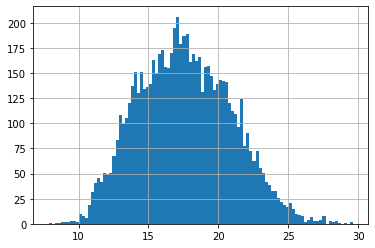

In [57]:
df[mask]['avg(air_temp_c)'].hist(bins=100);

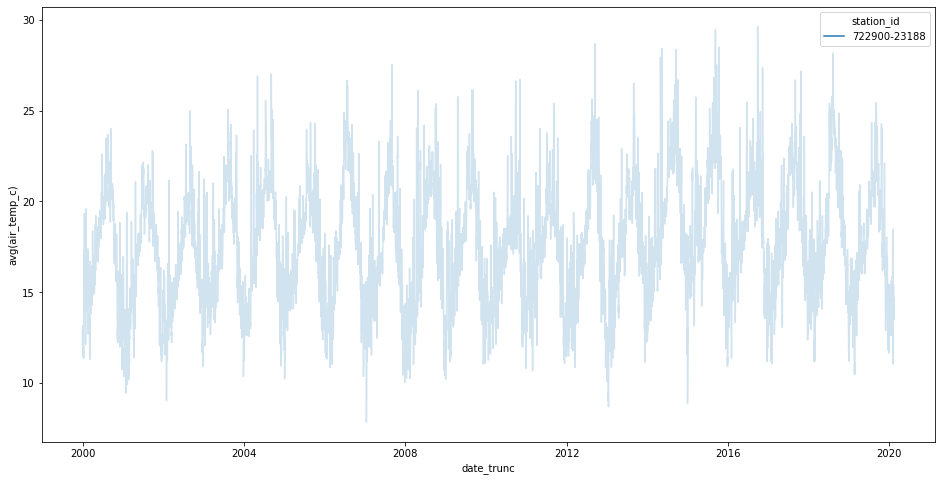

In [58]:
fig_dims = (16, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(data=df[mask],
             sort=True,
             alpha=0.2,
             x='date_trunc',
             y='avg(air_temp_c)',
             hue='station_id',
             ax=ax)